In [1]:
import math
from random import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def gws(x, R):
    if x < R:
        return 1
    else:
        return 1 * np.exp((-x + R))


def inv_Gws(r, R):
    if r < R:
        result = r
    else:
        result = R - np.log(1 + (R - r))
    return result


def wsdensity(r, R, a):
    return 1. / (1 + np.exp((r - R) / a))


def WSP(R, a):
    fmax = 1
    xmin = 0
    xmax = (R + 1)

    # picks random x points
    x1 = xmax * random()
    y1 = gws(x1, R) * random()

    while y1 > wsdensity(x1, R, a):
        x1 = xmax * random()
        y1 = gws(x1, R) * random()

    r = inv_Gws(x1, R)
    phi = 2*np.pi*random()
    theta = np.pi*random()
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

def boxsampler(R,a):
    fmax = 1
    xmin = 0
    xmax = 2*R

    # picks random x points
    x1 = xmax * random()
    y1 = fmax * random()

    while y1 > wsdensity(x1, R, a):
        x1 = xmax * random()
        y1 = fmax * random()

    r = x1
    phi = 2*np.pi*random()
    theta = np.pi*random()
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z, r

# The nucleon class contains nucleon coordinates, and methods for geometry.
class Nucleon:
    def __init__(self, x, y, z):
        self.bx = x
        self.by = y
        self.bz = z

    # Radial coordinate.
    def r(self):
        return np.sqrt(self.bx**2 + self.by**2+ self.bz**2)

    # Distance between this nucleon and another.
    def dist(self, other):
        dx2 = (self.bx - other.bx) ** 2
        dy2 = (self.by - other.by) ** 2
        dz2 = (self.bz - other.bz) ** 2
        return math.sqrt(dx2 + dy2 + dz2)

    # (x,y)-distance between this nucleon and another.
    def dist2(self, other):
        dx2 = (self.bx - other.bx) ** 2
        dy2 = (self.by - other.by) ** 2
        return math.sqrt(dx2 + dy2)

    # Shift the nucleon's coordinates by an impact parameter.
    def shift(self, r, phi):
        self.bx += r * math.cos(phi)
        self.by += r * math.sin(phi)



class Nucleus:
    def __init__(self, A):
        self.A = A
        # Glissando parametrization
        self.R = 1.1 * math.pow(float(self.A), 1.0 / 3.0) - 0.656 * math.pow(float(self.A), -1.0 / 3.0)
        self.aWs = 0.459
        self.hc = 0.9
        self.nucleons = []

    # This is a deliberately silly method of sampling from the WS distribution.
    # First sample from a box, and then reject. It will not fully catch the tail of
    # the distribution.
    def setup(self):
        while len(self.nucleons) < self.A:
            overlap = True
            while overlap:
                w = x = y = z = 0.
                u = 1.
                while w < u:
                    x = 2*self.R*(random() - 0.5)
                    y = 2*self.R*(random() - 0.5)
                    z = 2*self.R*(random() - 0.5)
                    r = math.sqrt(x*x + y*y + z*z)
                    w = 1./(1 + math.exp((r - self.R)/self.aWs))
                    u = random()
                n = Nucleon(x, y, z)    
                overlap = False
                for no in self.nucleons:
                    if no.dist(n) < self.hc:
                        overlap = True
                        break
            self.nucleons.append(n)



def impactsampler(bMax):
    b = np.sqrt(bMax**2*random())
    phi = 2*np.pi*random()
    return b, phi

def collision_bDisk(nuclei, impact, rDisk):
    Ncoll = []
    Ncoll_all = []
    for nu, bb in zip(nuclei, impact):
        nc = 0
        # Make a proton.
        proton = Nucleon(0,0,0)
        # Shift the impact parameter of the proton
        proton.shift(bb[0],bb[1])
        # Loop over all nucleons in nucleus, and check for overlap.
        for n in nu.nucleons:
            if n.dist2(proton) <= rDisk:
                nc += 1
        Ncoll_all.append(nc)
        if nc > 0:
            Ncoll.append(nc)

    return Ncoll, Ncoll_all


def collision_gDisk(nuclei, impact, rDisk, alpha):
    Ncoll = []
    Ncoll_all = []
    for nu, bb in zip(nuclei, impact):
        nc = 0
        # Make a proton.
        proton = Nucleon(0,0,0)
        # Shift the impact parameter of the proton
        proton.shift(bb[0],bb[1])
        # Loop over all nucleons in nucleus, and check for overlap.
        for n in nu.nucleons:
            x1 = random()
            if alpha>=x1:
                if n.dist2(proton) <= rDisk:
                    nc += 1
        Ncoll_all.append(nc)
        if nc > 0:
            Ncoll.append(nc)

    return Ncoll, Ncoll_all

def gscatter(axes, xArray, yArray, radius=1.25, **kwargs):
    # Filter arguments for labels.
    newarg = {}
    for key,value in kwargs.items():
        if key != "label":
            newarg[key] = value
    # Set a sensible axis range.
    try:
        axes.axis([min(-10,min(xArray)), max(10,max(xArray)), min(-10,min(yArray)), max(10,max(yArray))])
    except:
        axes.axis([-10,10,-10,10])
    # Go through the nucleons.
    for x, y in zip(xArray, yArray):
        # Add the first with a label.
        if x == xArray[0]:
            circle = Circle((x,y), radius=radius, **kwargs)
            axes.add_patch(circle)
        else:
            # Add the rest without.
            circle = Circle((x,y), radius=radius, **newarg)
            axes.add_patch(circle)
    # Make the figure presentation worthy.
    axes.set_xlabel("x [fm]")
    axes.set_ylabel("y [fm]")
    axes.set_aspect("equal")
    leg = axes.legend(scatterpoints=1)
    for l in leg.legendHandles:
        l._sizes = [30]
    return True

    
def T_bDisk(b,R):
    if b<R:
        return 1
    else:
        return 0

def sigmatot_bDisk(b_arr, R):
    V = 10*max(b_arr)**2*np.pi
    I = 0
    Ts_bDisk = np.zeros_like(b_arr)
    for i in range(len(b_arr)):
        Ts_bDisk[i] = T_bDisk(b_arr[i], R)
        I+=2*Ts_bDisk[i]
    I=V*1/(len(b_arr))*I
    return I, Ts_bDisk

def sigmael_bDisk(b_arr, R):
    V = 10*max(b_arr)**2*np.pi
    I = 0
    Ts_bDisk = np.zeros_like(b_arr)
    for i in range(len(b_arr)):
        Ts_bDisk[i] = T_bDisk(b_arr[i], R)
        I+=Ts_bDisk[i]**2
    I=V*1/(len(b_arr))*I
    return I, Ts_bDisk

def T_gDisk(b, R, alpha):
    u = random()
    if (b<=R) and u<=alpha:
        return 1
    else:
        return 0

def sigmatot_gDisk(b_arr, R, alpha):
    V = 10*max(b_arr)**2*np.pi
    I = 0
    Ts_gDisk = np.zeros_like(b_arr)
    for i in range(len(b_arr)):
        Ts_gDisk[i] = T_gDisk(b_arr[i], R, alpha)
        I+=2*Ts_gDisk[i]
    I=V*1/len(b_arr)*I
    return I, Ts_gDisk

def sigmael_gDisk(b_arr, R, alpha):
    V = 10*max(b_arr)**2*np.pi
    I = 0
    Ts_gDisk = np.zeros_like(b_arr)
    for i in range(len(b_arr)):
        Ts_gDisk[i] = T_gDisk(b_arr[i], R, alpha**2)  # change back to T_bDisk again if it don't work
        I+=Ts_gDisk[i]
    I=V*1/len(b_arr)*I
    return I, Ts_gDisk




In [2]:
nuclei = []
bMax = 7
num_impact = 10000
num_nuc = 10000
A=63
rDisk = np.sqrt(4.39/np.pi)
alpha = 0.5
g_rDisk = np.sqrt(rDisk**2/alpha)


for i in range(num_nuc):
    Au = Nucleus(A)
    if (i)%(num_nuc/10)==0:
                print(f'setup {i/num_nuc*100}% complete')
    Au.setup()
    nuclei.append(Au)


impact = []
for i in range(num_impact):
    impact.append(impactsampler(bMax))

b_arr = [bb[0] for bb in impact]
phi_arr = [pp[1] for pp in impact]


Ncoll, Ncoll_all = collision_bDisk(nuclei, impact, rDisk)
Ncoll_g, Ncoll_all_g = collision_gDisk(nuclei, impact, g_rDisk, alpha)



setup 0.0% complete
setup 10.0% complete
setup 20.0% complete
setup 30.0% complete
setup 40.0% complete
setup 50.0% complete
setup 60.0% complete
setup 70.0% complete
setup 80.0% complete
setup 90.0% complete


In [3]:

# getting the mean value total cross section for the black disk and gray disk for 200 GeV
num_barrs = 10000
bMax_p = 2
def cross_section_calc(num_barrs, bMax_p, rDisk, g_rDisk, alpha, num_impact):
    sigmatot_barr = np.zeros(num_barrs)
    sigmatot_garr = np.zeros(num_barrs)
    Ts_bDisk_list = []
    Ts_gDisk_list = []

    for i in range(num_barrs):
        impacts = []
        if (i % (num_barrs/10)) == 0:
            print(f'calculating cross section {i/num_barrs*100}% done')
        for j in range(num_impact):
            impacts.append(impactsampler(bMax_p))

        b_arrs = [bb[0] for bb in impacts]

        sigmatot_b, Ts_bDisk = sigmatot_bDisk(b_arrs, rDisk)
        sigmatot_g, Ts_gDisk = sigmatot_gDisk(b_arrs, g_rDisk, alpha)
        
        sigmatot_barr[i] = sigmatot_b
        sigmatot_garr[i] = sigmatot_g

        Ts_bDisk_list.append(Ts_bDisk)
        Ts_gDisk_list.append(Ts_gDisk)

    s_b_mean = np.mean(sigmatot_barr)
    s_g_mean = np.mean(sigmatot_garr)

    s_b_std = np.std(sigmatot_barr)
    s_g_std = np.std(sigmatot_garr)
    return s_b_mean, s_b_std, s_g_mean, s_g_std, Ts_bDisk_list, Ts_gDisk_list

s_b_mean, s_b_std, s_g_mean, s_g_std, Ts_bDisk_list, Ts_gDisk_list = cross_section_calc(num_barrs, bMax_p, rDisk, g_rDisk, alpha, num_impact)
print(r'$\sigma_{tot}^pp$ black disk sim =',s_b_mean, r'$\pm$',s_b_std ,'[mb]') 
print(r'$\sigma_{tot}^pp$ black disk analytical =',10*2*np.pi*rDisk**2,'[mb]')

print(r'$\sigma_{tot}^pp$ gray disk sim =',s_g_mean, r'$\pm$', s_g_std ,'[mb]') 
print(r'$\sigma_{tot}^pp$ gray disk analytical =',10*2*np.pi*alpha*g_rDisk**2,'[mb]')

calculating cross section 0.0% done
calculating cross section 10.0% done
calculating cross section 20.0% done
calculating cross section 30.0% done
calculating cross section 40.0% done
calculating cross section 50.0% done
calculating cross section 60.0% done
calculating cross section 70.0% done
calculating cross section 80.0% done
calculating cross section 90.0% done
$\sigma_{tot}^pp$ black disk sim = 87.79456085493814 $\pm$ 1.1894906879424443 [mb]
$\sigma_{tot}^pp$ black disk analytical = 87.8 [mb]
$\sigma_{tot}^pp$ gray disk sim = 87.79166616655722 $\pm$ 1.1921261371160143 [mb]
$\sigma_{tot}^pp$ gray disk analytical = 87.8 [mb]


float64 float64 float64 float64
gray disk: b = 0.23134420940481334, a/c = 1.4260459346322787, d = 1.0928687899675074, alpha = 0.5066928104039311
black disk: b = 0.309085545949851, a/c = 1.9719169678857207, d = 0.7430612060965783


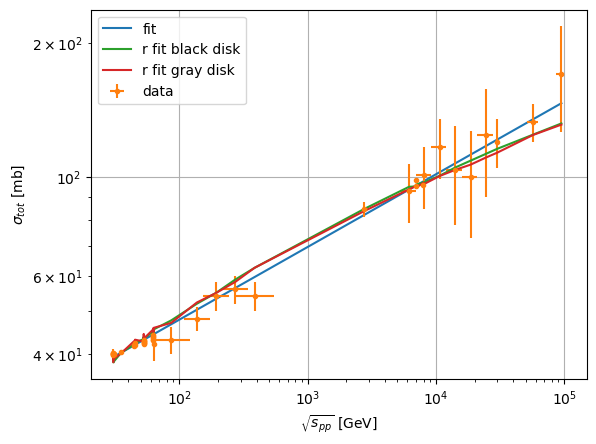

In [4]:
import pandas as pd
from scipy.optimize import curve_fit



m_p = 0.938 # GeV/c^2
def plab_to_sqrts(df, k):
        sqrt_s = np.sqrt(2*(m_p**2+m_p*np.sqrt(m_p**2+df[k]**2)))
        return sqrt_s

def data_setup(data):
    df = pd.read_csv(data, sep='\s+', header=None)
    p_lab = df[1]

    

    sqrt_s = np.sqrt(2*(m_p**2+m_p*np.sqrt(m_p**2+p_lab**2)))
    df[14] = sqrt_s

    E_min = 30 # GeV
    # disregarding all resluts with a std of 0 and energy less than E_min
    df = df[(df[5]!=0) & (df[6]!=0) & (df[14]>E_min)].reset_index()

    sqrt_s = df[14]
    sqrt_s_stam = sqrt_s - plab_to_sqrts(df, 2)
    sqrt_s_stap =  plab_to_sqrts(df, 3) - sqrt_s
    sig = df[4]
    sta_errp = df[5]
    sta_errm = df[6]
    sorted_sqrt_s = np.sort(sqrt_s)
    return sorted_sqrt_s, sqrt_s, sqrt_s_stam, sqrt_s_stap, sig, sta_errm, sta_errp


sorted_sqrt_s, sqrt_s, sqrt_s_stam, sqrt_s_stap, sig, sta_errm, sta_errp = data_setup('cross_section_data.csv')

print(sqrt_s.dtype, sqrt_s_stam.dtype, sig.dtype, sta_errp.dtype )

# making a fit out of the data
def cross_fit(sqrt_s,a,b):
    return np.exp(a*np.log(sqrt_s)+b)


popt_E, pcov_E = curve_fit(cross_fit, xdata=sqrt_s, ydata=sig, sigma=sta_errm, absolute_sigma=True)
a, b = popt_E # will come in handy when doing fits for rDisk
perr_E = np.sqrt(np.diag(pcov_E))
sorted_sqrt_s = np.sort(sqrt_s)

plt.plot(sorted_sqrt_s, cross_fit(sorted_sqrt_s,*popt_E), label='fit')

plt.errorbar(x=sqrt_s, y=sig,  xerr=[sqrt_s_stam,sqrt_s_stap], yerr=[sta_errm,sta_errp], marker='.', linestyle='none', label='data')
plt.ylabel(r'$\sigma_{tot}$ [mb]')
plt.xlabel(r'$\sqrt{s_{pp}}$ [GeV]')
plt.yscale('log')
plt.xscale('log')
plt.grid()

def rDisk_fit(sqrt_s,b,c,d):
    rDisk = a/c*np.log(d*sqrt_s)+b
    return rDisk

def sig_fit_b(sqrt_s,b,c,d):
    bMax_p=2
    num_barrs=100
    num_impact=1000
    sigmatot_barr = np.zeros(num_barrs)
    s_b_mean_arr = np.zeros(len(sqrt_s))
    r = rDisk_fit(sqrt_s,b,c,d)
    for k in range(len(sqrt_s)):
        for i in range(num_barrs):
            impacts = []
            for j in range(num_impact):
                impacts.append(impactsampler(bMax_p))

            b_arrs = [bb[0] for bb in impacts]

            sigmatot_b, _ = sigmatot_bDisk(b_arrs, r[k])

            sigmatot_barr[i] = sigmatot_b
        
        s_b_mean = np.mean(sigmatot_barr)
        s_b_mean_arr[k] = s_b_mean
    return s_b_mean_arr

def sig_fit_g(sqrt_s, b, c, d, alpha):
    bMax_p=3
    num_barrs=100
    num_impact=1000
    sigmatot_barr = np.zeros(num_barrs)
    s_g_mean_arr = np.zeros(len(sqrt_s))
    r = rDisk_fit(sqrt_s, b, c, d)
    for k in range(len(sqrt_s)):
        for i in range(num_barrs):
            impacts = []
            for j in range(num_impact):
                impacts.append(impactsampler(bMax_p))

            b_arrs = [bb[0] for bb in impacts]
            sigmatot_g, _ = sigmatot_gDisk(b_arrs, r[k], alpha)

            sigmatot_barr[i] = sigmatot_g

        s_g_mean = np.mean(sigmatot_barr)
        s_g_mean_arr[k] = s_g_mean
    return s_g_mean_arr

# want to make a fit and compare it to the original fit
popt_g, pcov_g = curve_fit(sig_fit_g, xdata=sqrt_s, ydata=sig, sigma=sta_errm, p0=[1/2, 2, 1, 1/2], bounds=((-np.inf, -np.inf, -np.inf,  0.2), (np.inf, np.inf, np.inf,  0.8)), method='trf', diff_step=0.1) # make bounds for alpha [0,1]
print(f'gray disk: b = {a/popt_g[0]}, a/c = {popt_g[1]}, d = {popt_g[2]}, alpha = {popt_g[3]}')
popt_b, pcov_b = curve_fit(sig_fit_b, xdata=sqrt_s, ydata=sig, sigma=sta_errm, p0=[1/2,2, 1], method='lm', epsfcn=0.1)
print(f'black disk: b = {a/popt_b[0]}, a/c = {popt_b[1]}, d = {popt_b[2]}')
plt.plot(sorted_sqrt_s, sig_fit_b(sorted_sqrt_s, *popt_b), label='r fit black disk')
plt.plot(sorted_sqrt_s, sig_fit_g(sorted_sqrt_s, *popt_g), label='r fit gray disk')
plt.legend()
plt.show()


[ 39.42402581  39.42402581  39.42402581  39.42402581  39.42402581
  39.4240707   39.44503272  39.46598177  40.33586118  41.94034434
  41.94045621  41.97103757  42.01669628  43.09649668  43.09649668
  43.09649668  43.09649668  43.09649668  43.10976108  43.14963487
  44.27654029  44.28825962  44.29971685  44.32283118  44.32283118
  44.334365    44.35738709  46.70958121  50.35591188  53.27683125
  56.36726072  59.63704669  82.22179252  93.74801322  95.71486195
  95.71486195  97.82419073  98.0739385  102.59981744 107.33434113
 112.28751848 117.46913559 121.38658563 134.79795085 146.52205398]
[ 39.23927267  37.77698387  38.9284749   39.3743164   37.65757705
  39.14232365  39.81599531  38.33352699  39.69908153  43.18335163
  42.59168372  42.13055389  41.66313845  43.22200583  44.42223943
  43.10749327  43.52510236  43.54375301  43.9058621   42.96993559
  44.56499616  45.93845036  45.7263433   45.68220502  44.72983385
  44.52923635  45.08574126  48.16801184  51.72534296  55.63828433
  57.1971

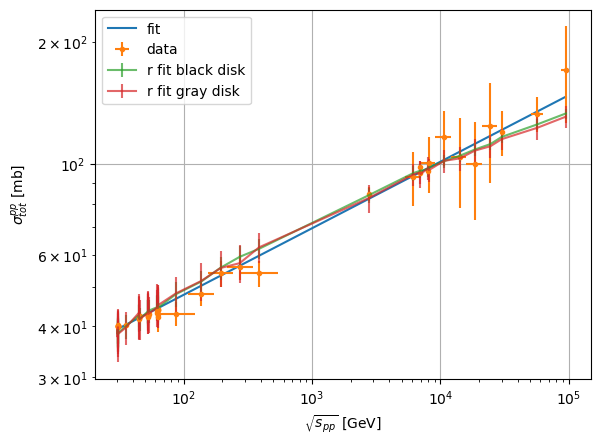

In [5]:
sorted_sqrt_s, sqrt_s, sqrt_s_stam, sqrt_s_stap, sig, sta_errm, sta_errp = data_setup('cross_section_data.csv')

def sig_fit_b_mean_std(sqrt_s,b,c,d):
    bMax_p=2
    num_barrs=100
    num_impact=1000
    sigmatot_barr = np.zeros(num_barrs)
    s_b_mean_arr = np.zeros(len(sqrt_s))
    s_b_std_arr = np.zeros(len(sqrt_s))
    r = rDisk_fit(sqrt_s,b,c,d)
    for k in range(len(sqrt_s)):
        for i in range(num_barrs):
            impacts = []
            for j in range(num_impact):
                impacts.append(impactsampler(bMax_p))

            b_arrs = [bb[0] for bb in impacts]

            sigmatot_b, _ = sigmatot_bDisk(b_arrs, r[k])

            sigmatot_barr[i] = sigmatot_b
        
        s_b_mean = np.mean(sigmatot_barr)
        s_b_mean_arr[k] = s_b_mean
        s_b_std = np.std(sigmatot_barr)
        s_b_std_arr[k] = s_b_std
    return s_b_mean_arr, s_b_std_arr

def sig_fit_g_mean_std(sqrt_s, b, c, d, alpha):
    bMax_p=3
    num_barrs=100
    num_impact=1000
    sigmatot_barr = np.zeros(num_barrs)
    s_g_mean_arr = np.zeros(len(sqrt_s))
    s_g_std_arr = np.zeros(len(sqrt_s))
    r = rDisk_fit(sqrt_s, b, c, d)
    for k in range(len(sqrt_s)):
        for i in range(num_barrs):
            impacts = []
            for j in range(num_impact):
                impacts.append(impactsampler(bMax_p))

            b_arrs = [bb[0] for bb in impacts]
            sigmatot_g, _ = sigmatot_gDisk(b_arrs, r[k], alpha)

            sigmatot_barr[i] = sigmatot_g

        s_g_mean = np.mean(sigmatot_barr)
        s_g_mean_arr[k] = s_g_mean
        s_g_std = np.std(sigmatot_barr)
        s_g_std_arr[k] = s_g_std
    print(s_g_mean_arr)
    print(s_g_std_arr)
    return s_g_mean_arr, s_g_std_arr

plt.plot(sorted_sqrt_s, cross_fit(sorted_sqrt_s,*popt_E), label='fit')
print(cross_fit(sorted_sqrt_s,*popt_E))

plt.errorbar(x=sqrt_s, y=sig,  xerr=[sqrt_s_stam,sqrt_s_stap], yerr=[sta_errm,sta_errp], marker='.', linestyle='none', label='data')
plt.ylabel(r'$\sigma_{tot}^{pp}$ [mb]')
plt.xlabel(r'$\sqrt{s_{pp}}$ [GeV]')
plt.yscale('log')
plt.xscale('log')
plt.grid()
mean_b, std_b = sig_fit_b_mean_std(sorted_sqrt_s, *popt_b)
mean_g, std_g = sig_fit_g_mean_std(sorted_sqrt_s, *popt_g)

plt.errorbar(sorted_sqrt_s, mean_b, yerr=std_b, alpha=0.7, label='r fit black disk')
plt.errorbar(sorted_sqrt_s, mean_g, yerr=std_g, alpha=0.7, label='r fit gray disk')
plt.legend()
plt.show()

[12.94749987 12.96421031 13.21277215 13.23314628 13.14255524 14.57109147
 13.92130105 14.74538261 15.05605561 14.9913686  14.96522309 15.86153673
 15.71716242 32.40606876 37.63781013 37.10362901 38.23317562 37.65750976]
[ 51.82218478  51.34438734  51.86916542  51.59653837  50.72831622
  56.6365296   56.72161371  58.19016813  58.65195937  58.8632016
  58.51922244  61.27955895  61.79305408 126.67476229 147.42088354
 148.06249937 151.73300331 150.68521627]


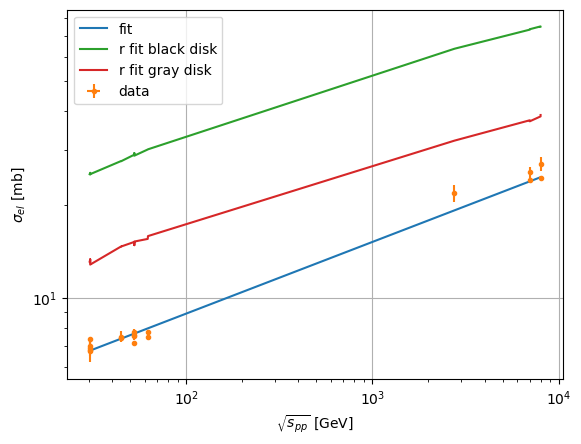

In [6]:
sorted_sqrt_s, sqrt_s, sqrt_s_stam, sqrt_s_stap, sig, sta_errm, sta_errp = data_setup('el_cross_section_data.csv')

popt_EL, pcov_EL = curve_fit(cross_fit, xdata=sqrt_s, ydata=sig, sigma=sta_errm, absolute_sigma=True)
a, b = popt_EL # will come in handy when doing fits for rDisk
perr_EL = np.sqrt(np.diag(pcov_E))
sorted_sqrt_s = np.sort(sqrt_s)

plt.plot(sorted_sqrt_s, cross_fit(sorted_sqrt_s,*popt_EL), label='fit')

plt.errorbar(x=sqrt_s, y=sig,  xerr=[sqrt_s_stam,sqrt_s_stap], yerr=[sta_errm,sta_errp], marker='.', linestyle='none', label='data')
plt.ylabel(r'$\sigma_{el}$ [mb]')
plt.xlabel(r'$\sqrt{s_{pp}}$ [GeV]')
plt.yscale('log')
plt.xscale('log')
plt.grid()

def sigel_fit_b(sqrt_s, b ,c , d):
    bMax_p=2
    num_barrs=100
    num_impact=1000
    sigmatot_barr = np.zeros(num_barrs)
    s_b_mean_arr = np.zeros(len(sqrt_s))
    r = rDisk_fit(sqrt_s, b, c, d)
    for k in range(len(sqrt_s)):
        for i in range(num_barrs):
            impacts = []
            for j in range(num_impact):
                impacts.append(impactsampler(bMax_p))

            b_arrs = [bb[0] for bb in impacts]

            sigmatot_b, _ = sigmael_bDisk(b_arrs, r[k])

            sigmatot_barr[i] = sigmatot_b
        
        s_b_mean = np.mean(sigmatot_barr)
        s_b_mean_arr[k] = s_b_mean
    return s_b_mean_arr

def sigel_fit_g(sqrt_s, b, c, d, alpha):
    bMax_p=3
    num_barrs=100
    num_impact=1000
    sigmatot_barr = np.zeros(num_barrs)
    s_g_mean_arr = np.zeros(len(sqrt_s))
    r = rDisk_fit(sqrt_s, b, c, d)
    for k in range(len(sqrt_s)):
        for i in range(num_barrs):
            impacts = []
            for j in range(num_impact):
                impacts.append(impactsampler(bMax_p))

            b_arrs = [bb[0] for bb in impacts]
            sigmatot_g, _ = sigmael_gDisk(b_arrs, r[k], alpha)

            sigmatot_barr[i] = sigmatot_g

        s_g_mean = np.mean(sigmatot_barr)
        s_g_mean_arr[k] = s_g_mean
    return s_g_mean_arr

# want to make a fit and compare it to the original fit
plt.plot(sorted_sqrt_s, sigel_fit_b(sorted_sqrt_s, *popt_b), label='r fit black disk')
plt.plot(sorted_sqrt_s, sigel_fit_g(sorted_sqrt_s, *popt_g), label='r fit gray disk')
print(sigel_fit_g(sorted_sqrt_s, *popt_g))
print(sig_fit_g(sorted_sqrt_s, *popt_g))
plt.legend()
plt.show()

[13.10459866 13.12673194 13.09554991 13.05271643 12.85034086 14.51752562
 14.05380871 15.09443416 15.2198136  14.81480674 15.04198983 15.80623764
 15.42720486 32.23065971 37.21298489 37.33621517 38.30165485 38.04628769]
[ 50.95264627  50.8280788   52.19553786  51.00313838  52.58545825
  57.28457074  56.59385957  58.70641553  59.07217416  59.16787037
  59.45677979  61.38193433  61.64876465 127.74010928 147.90164213
 147.79112697 150.10635962 149.21694871]


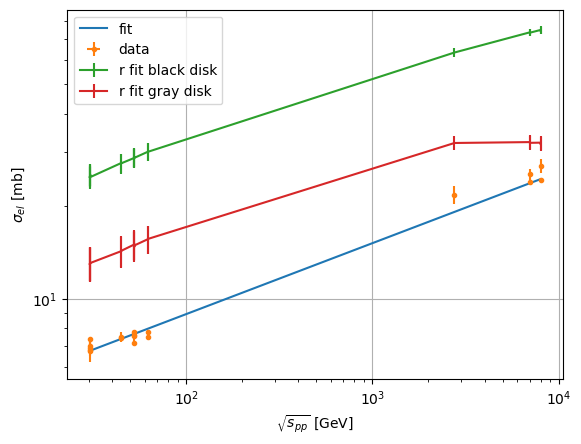

In [7]:

def sigel_fit_b_mean_std(sqrt_s,b,c,d):
    bMax_p=2
    num_barrs=100
    num_impact=1000
    sigmatot_barr = np.zeros(num_barrs)
    s_b_mean_arr = np.zeros(len(sqrt_s))
    s_b_std_arr = np.zeros(len(sqrt_s))
    r = rDisk_fit(sqrt_s,b,c,d)
    for k in range(len(sqrt_s)):
        for i in range(num_barrs):
            impacts = []
            for j in range(num_impact):
                impacts.append(impactsampler(bMax_p))

            b_arrs = [bb[0] for bb in impacts]

            sigmatot_b, _ = sigmael_bDisk(b_arrs, r[k])

            sigmatot_barr[i] = sigmatot_b
        
        s_b_mean = np.mean(sigmatot_barr)
        s_b_mean_arr[k] = s_b_mean
        s_b_std = np.std(sigmatot_barr)
        s_b_std_arr[k] = s_b_std
    return s_b_mean_arr, s_b_std

def sigel_fit_g_mean_std(sqrt_s,b,c,d, alpha):
    bMax_p=2
    num_barrs=100
    num_impact=1000
    sigmatot_barr = np.zeros(num_barrs)
    s_b_mean_arr = np.zeros(len(sqrt_s))
    s_b_std_arr = np.zeros(len(sqrt_s))
    r = rDisk_fit(sqrt_s,b,c,d)
    for k in range(len(sqrt_s)):
        for i in range(num_barrs):
            impacts = []
            for j in range(num_impact):
                impacts.append(impactsampler(bMax_p))

            b_arrs = [bb[0] for bb in impacts]

            sigmatot_b, _ = sigmael_gDisk(b_arrs, r[k], alpha)

            sigmatot_barr[i] = sigmatot_b
        
        s_b_mean = np.mean(sigmatot_barr)
        s_b_mean_arr[k] = s_b_mean
        s_b_std = np.std(sigmatot_barr)
        s_b_std_arr[k] = s_b_std
    return s_b_mean_arr, s_b_std

el_mean_b, el_std_b = sigel_fit_b_mean_std(sorted_sqrt_s, *popt_b)
el_mean_g, el_std_g = sigel_fit_g_mean_std(sorted_sqrt_s, *popt_g)
plt.plot(sorted_sqrt_s, cross_fit(sorted_sqrt_s,*popt_EL), label='fit')

plt.errorbar(x=sqrt_s, y=sig,  xerr=[sqrt_s_stam,sqrt_s_stap], yerr=[sta_errm,sta_errp], marker='.', linestyle='none', label='data')
plt.ylabel(r'$\sigma_{el}$ [mb]')
plt.xlabel(r'$\sqrt{s_{pp}}$ [GeV]')
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.errorbar(sorted_sqrt_s, el_mean_b, yerr=el_std_b, label='r fit black disk')
plt.errorbar(sorted_sqrt_s, el_mean_g, yerr=el_std_g, label='r fit gray disk')
print(sigel_fit_g(sorted_sqrt_s, *popt_g))
print(sig_fit_g(sorted_sqrt_s, *popt_g))
plt.legend()
plt.show()

In [8]:
def r_vals(r, y): # calculates the values of r from the pascal triangel
    rs = []
    yfloor = math.floor(y)
    n = int(yfloor/2)
    num_rs = np.zeros(n+1)
    for k in range(int(yfloor/2)+1):
        for i in range(math.comb(n,k)):
            num_rs[k] += 1
            rs.append(r/(3**(k)))
    return rs, num_rs


r_list, num_rlist = r_vals(1, 8)
print(r_list)
print(num_rlist)


[1.0, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.012345679012345678]
[1. 4. 6. 4. 1.]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


$\gamma p$ total cross section = 0.029382044310443407 [mb] at 75 GeV
$\gamma p$ elastic cross section = 6.0048567467459726e-05 [mb] at 75 GeV


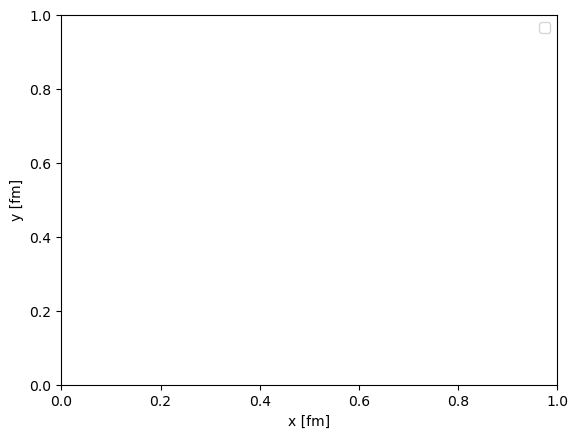

simplest dipole
fij calculated = 0.011626962936820482
fij analytical = 0.011626962936820473


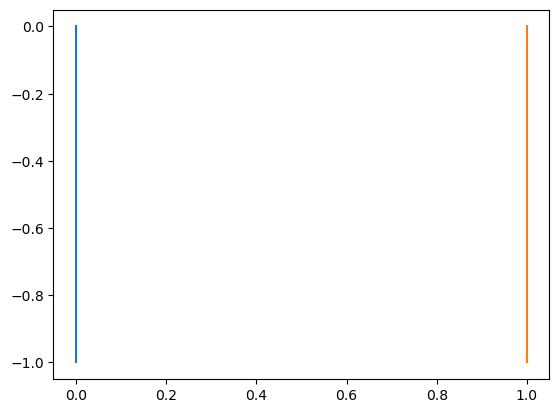

In [43]:
# virtual photon-proton collision with dipoles
alpha_s = 0.22

def angle_rs(r1, r2):
    angle = np.arccos(1-1/2*(r2/r1)**2)
    return angle

def dip_Proton(x, y):
        
    r_quarks = 5.068/(3*m_p) # [fm]
    dist1 = r_quarks/2*np.tan(np.pi/6)

    quark_1 = np.array([-r_quarks/2, -dist1, 0]) # (x, y, z) i.e nodes will later discard z????
    quark_2 = np.array([0, dist1, 0])
    quark_3 = np.array([r_quarks/2, -dist1, 0])
    
    theta_z = random()*2*np.pi
    Rz = np.array([[np.cos(theta_z), -np.sin(theta_z), 0],
                [np.sin(theta_z), np.cos(theta_z), 0],
                [0, 0, 1]])

    theta_x = random()*2*np.pi  # Rotate by 60 degrees

    Rx = np.array([[1, 0, 0],
                [0, np.cos(theta_x), -np.sin(theta_x)],
                [0, np.sin(theta_x), np.cos(theta_x)]])

    theta_y = random()*2*np.pi

    Ry = np.array([[np.cos(theta_y), 0, np.sin(theta_y)],
                        [0, 1, 0],
                        [-np.sin(theta_y), 0, np.cos(theta_y)]])

    xy = np.array([x,y])
    quark_1 = quark_1 @ Rx @ Rz @ Ry 
    quark_2 = quark_2 @ Rx @ Rz @ Ry
    quark_3 = quark_3 @ Rx @ Rz @ Ry

    quark_1 = quark_1[:-1]+xy
    quark_2 = quark_2[:-1]+xy
    quark_3 = quark_3[:-1]+xy

    # dipoles contains two nodes
    dipTargets = [[quark_1, quark_2], [quark_1, quark_3], [quark_2, quark_3]] # "proton" with quarks in a equilateral triangel

    return dipTargets
dipTargets = dip_Proton(0,0)
num_dip_impact = 10000 # the number of impact parameters we sample the cross sections from
impacts_dip = []
b_max = 7
for j in range(num_dip_impact): # initializes impact parameters with a maximum b
    impacts_dip.append(impactsampler(b_max))

b_dip = [bb[0] for bb in impacts_dip]
phi_dip = [bb[1] for bb in impacts_dip]


def r_vals(r, y): # calculates the values of r from the pascal triangel
    rs = []
    yfloor = math.floor(y)
    n = int(yfloor/2)
    num_rs = np.zeros(n+1)
    for k in range(int(yfloor/2)+1):
        for i in range(math.comb(n,k)):
            num_rs[k] += 1
            rs.append(r/(3**(k)))

    alpha = angle_rs(1, 1)
    beta = angle_rs(1, 1/3)
    return rs, num_rs, alpha, beta



def dipole_mother(r, impact, psi): # first dipole
    b = impact[0]
    phi = impact[1]
    r1 = np.array([b*np.cos(phi)+r/2*np.cos(psi), b*np.sin(phi)+r/2*np.sin(psi)])
    r2 = np.array([b*np.cos(phi)+r/2*np.cos(psi), b*np.sin(phi)+r/2*np.sin(psi)])
    xs = [r1[0], r2[0]]
    ys = [r1[1], r2[1]]
    # plt.plot(xs, ys, label='mother') # plot mother
    r_dip_proj = [r1, r2]
    return r_dip_proj, r2

def dipole_daughter(r, r_last, theta): # function for daughter dipoles
    r1 = r_last
    r2 = np.array([r1[0]+r*np.cos(theta), r1[1]+r*np.sin(theta)])
    xs = [r1[0], r2[0]]
    ys = [r1[1], r2[1]]
    # plt.plot(xs, ys) # plot the dipoles
    r_dip_proj = [r1, r2]
    return r_dip_proj, r2

def dipProj_sampling(impact, r_list, alpha, beta): # samples dipoles from an original impact parameter and then branches out
    dip_list = []
    psi = 2*np.pi*random()
    angleList = []
    if len(r_list)>1:
        dip_proj, r_last = dipole_mother(r_list[0], impact, psi)
        dip_list.append(dip_proj)
        angleList.append((beta+psi+np.pi))
        if len(r_list)>3:
            angleList.append((-np.pi+2*beta+alpha))
            angleList.append(beta+np.pi)
        if len(r_list)>5:
            angleList.append((3*beta+2*alpha))
            angleList.append((2*beta+alpha))
            angleList.append(beta)

        for i in range(1, len(angleList)):
            angleList[i] += angleList[i-1]

        for i in range(1, len(r_list)):
            theta = angleList[i-1]+psi
            dip_daughter, r_last = dipole_daughter(r_list[i], r_last, theta)
            dip_list.append(dip_daughter)
        return dip_list
    else:
        dip_list.append(dipole_mother(r_list[0], impact, psi)[0])
        return dip_list


def fij_calc(dipProj, dipTarget): # takes in a single dipole from projectile and target
    r_13_coords = dipProj[0] - dipTarget[0]
    r_14_coords = dipProj[0] - dipTarget[1]
    r_23_coords = dipProj[1] - dipTarget[0]
    r_24_coords = dipProj[1] - dipTarget[1]
    r_13 = np.sqrt(r_13_coords[0]**2+r_13_coords[1]**2)
    r_14 = np.sqrt(r_14_coords[0]**2+r_14_coords[1]**2)
    r_23 = np.sqrt(r_23_coords[0]**2+r_23_coords[1]**2)
    r_24 = np.sqrt(r_24_coords[0]**2+r_24_coords[1]**2)

    fij = alpha_s**2/2*np.log(r_13*r_24/(r_14*r_23))**2
    return fij

def T_gp(dipTargets, impact, r_list, alpha, beta): # calculates the scattering amplitude for a single impact parameter
    dipProj = dipProj_sampling(impact, r_list, alpha, beta)
    fij_arr = np.zeros((len(dipProj),len(dipTargets)))
    for i in range(len(dipProj)):
        for j in range(len(dipTargets)):
            fij_arr[i][j] = fij_calc(dipProj[i], dipTargets[j])
    T = 1 - np.exp(-np.sum(fij_arr))
    return T

def sigma_gp(dipTargets, impacts, Q): # calculates the total integrated cross section for gamma-p
    b_arr = [bb[0] for bb in impacts]
    V = 10*max(b_arr)**2*np.pi
    I_tot = 0
    I_el = 0
    Ts = np.zeros_like(b_arr)
    r = 5.068/Q
    y = np.log(Q/m_p)
    r_list, numList, alpha, beta = r_vals(r, y)
    for i in range(len(b_arr)):
        Ts[i] = T_gp(dipTargets, impacts[i], r_list, alpha, beta)
        I_tot+=2*Ts[i]
        I_el+=Ts[i]**2
    I_tot=V*1/len(b_arr)*I_tot
    I_el=V*1/len(b_arr)*I_el
    return I_tot, I_el


Q = 75 # GeV
sig_tot_gp, sig_el_gp = sigma_gp(dipTargets, impacts_dip, Q)
print(f'$\gamma p$ total cross section = {sig_tot_gp} [mb] at {Q} GeV')
print(f'$\gamma p$ elastic cross section = {sig_el_gp} [mb] at {Q} GeV')
plt.xlabel('x [fm]')
plt.ylabel('y [fm]')
plt.legend()
plt.show()

#simplest case calculating fij
d=1
r=1
dip_p = np.array([[0,0], [0,-r]])
dip_t = np.array([[d,0], [d,-r]])

xs1 = [0, 0]
xs2 = [d, d]
ys1 = [0, -r]
ys2 = [0, -r]
plt.plot(xs1, ys1)
plt.plot(xs2, ys2)
fij_simp = fij_calc(dip_p, dip_t)
print('simplest dipole')
print(f'fij calculated = {fij_simp}')
print(f'fij analytical = {alpha_s**2/2*np.log(2)**2}')

In [44]:
Q = 75.4
num_barrs = 100 # number of sampled cross sections (want to try more since large std but have to move to cluster. problem: running out of ram)
bMax_p = 3
num_impact = 1000 # number of impact parameters for each cross section

def cs_gamma_p(Q, num_barrs, bMax_p, num_impact):
    sigmatot_arr = np.zeros(num_barrs)
    sigmael_arr = np.zeros(num_barrs)

    for i in range(num_barrs):
        impacts = []
        if (i % (num_barrs/10)) == 0:
            print(f'calculating cross section {i/num_barrs*100}% done')
        for j in range(num_impact):
            impacts.append(impactsampler(bMax_p))

        sigmatot_gp, sigmael_gp = sigma_gp(dipTargets, impacts, Q)
        
        sigmatot_arr[i] = sigmatot_gp
        sigmael_arr[i] = sigmael_gp


    sigtot_mean = np.mean(sigmatot_arr)
    sigtot_std = np.std(sigmatot_arr)

    sigel_mean = np.mean(sigmael_arr)
    sigel_std = np.std(sigmael_arr)
    return sigtot_mean, sigtot_std, sigel_mean, sigel_std

sigtot_mean, sigtot_std, sigel_mean, sigel_std = cs_gamma_p(Q, num_barrs, bMax_p, num_impact)
print(r'tot cross section gamma-p =',sigtot_mean, r'$\pm$',sigtot_std ,f'[mb] at Q = {Q}') 
print(r'el cross section gamma-p =',sigel_mean, r'$\pm$',sigel_std ,f'[mb] at Q = {Q}') 

calculating cross section 0.0% done
calculating cross section 10.0% done
calculating cross section 20.0% done
calculating cross section 30.0% done
calculating cross section 40.0% done
calculating cross section 50.0% done
calculating cross section 60.0% done
calculating cross section 70.0% done
calculating cross section 80.0% done
calculating cross section 90.0% done
tot cross section gamma-p = 0.0414189459170441 $\pm$ 0.026635230583940774 [mb] at Q = 75.4
el cross section gamma-p = 0.0006853622858073758 $\pm$ 0.003107405748551102 [mb] at Q = 75.4


In [11]:
# gamma*-A cross section calculations

class Nucleus_dipole:
    def __init__(self, A):
        self.A = A
        # Glissando parametrization
        self.R = 1.1 * math.pow(float(self.A), 1.0 / 3.0) - 0.656 * math.pow(float(self.A), -1.0 / 3.0)
        self.aWs = 0.459
        self.hc = 0.9
        self.nucleons = []
        self.dipList = None

    # This is a deliberately silly method of sampling from the WS distribution.
    # First sample from a box, and then reject. It will not fully catch the tail of
    # the distribution.
    def setup(self):
        while len(self.nucleons) < self.A:
            overlap = True
            while overlap:
                w = x = y = z = 0.
                u = 1.
                while w < u:
                    x = 2*self.R*(random() - 0.5)
                    y = 2*self.R*(random() - 0.5)
                    z = 2*self.R*(random() - 0.5)
                    r = math.sqrt(x*x + y*y + z*z)
                    w = 1./(1 + math.exp((r - self.R)/self.aWs))
                    u = random()
                
                n = Nucleon(x, y, z)    
                overlap = False
                for no in self.nucleons:
                    if no.dist(n) < self.hc:
                        overlap = True
                        break
            if len(self.nucleons) == 0:
                self.dipList = [*dip_Proton(x,y)]
            else:
                for i in range(len(dip_Proton(x,y))):
                    self.dipList.append(dip_Proton(x,y)[i])
            self.nucleons.append(n)


# num_nuc_dip = 20
# num_impact = 1000
# nuc_dipList = []
# gA_totList = []
# gA_elList = []
# for i in range(num_nuc_dip):

#     nuc_dip = Nucleus_dipole(A)
#     nuc_dip.setup()

#     gA_tot, gA_el = sigma_gp(nuc_dip.dipList, impacts_dip, Q=75.4)

#     gA_totList.append(gA_tot)
#     gA_elList.append(gA_el)

#     if i % (num_nuc_dip/10) == 0:
#         print(f'cross section {i/num_nuc_dip*100}% complete')


# mean_gA_tot = np.mean(gA_totList)
# mean_gA_el = np.mean(gA_elList)

# std_gA_tot = np.std(gA_totList)
# std_gA_el = np.std(gA_elList)

# print(f'sigmatot gA = {mean_gA_tot} pm {std_gA_tot} [mb]')
# print(f'sigmael gA = {mean_gA_el} pm {std_gA_el} [mb]')


data for gamma-p sigtot = 0.148 [mb] at sqrt_s = 75.38915234249554 [GeV]


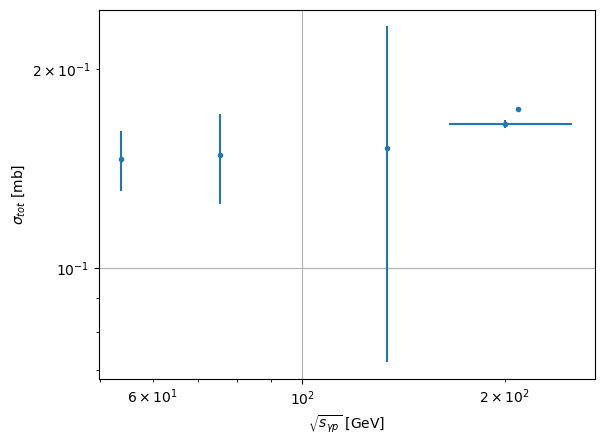

In [12]:
df = pd.read_csv('gamma_p_tot_cs.csv', sep='\s+', header=None, usecols=range(11))
p_lab = df[1]

sqrt_s = np.sqrt(m_p**2+2*p_lab*m_p)
df[12] = sqrt_s

E_min = 50 # GeV
# disregarding all resluts with a std of 0 and energy less than E_min
df = df[(df[5]!=0) & (df[6]!=0) & (df[12]>E_min)].reset_index()

sqrt_s = df[12]
sqrt_s_stam = sqrt_s - np.sqrt(m_p**2+2*df[2]*m_p)
sqrt_s_stap =  np.sqrt(m_p**2+2*df[3]*m_p) - sqrt_s
sig = df[4]
sta_errp = df[5]
sta_errm = df[6]
sorted_sqrt_s = np.sort(sqrt_s)

print(f'data for gamma-p sigtot = {sig[1]} [mb] at sqrt_s = {sqrt_s[1]} [GeV]')

plt.errorbar(x=sqrt_s, y=sig,  xerr=[sqrt_s_stam,sqrt_s_stap], yerr=[sta_errm,sta_errp], marker='.', linestyle='none', label='data')
plt.ylabel(r'$\sigma_{tot}$ [mb]')
plt.xlabel(r'$\sqrt{s_{\gamma p}}$ [GeV]')
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.show()

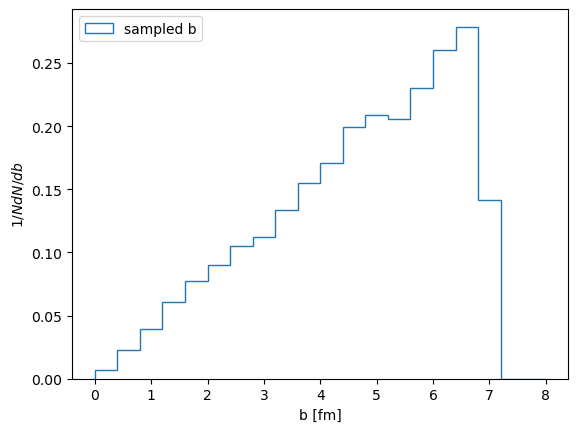

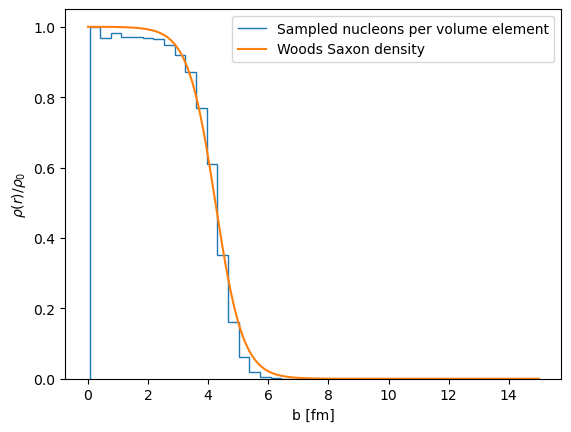

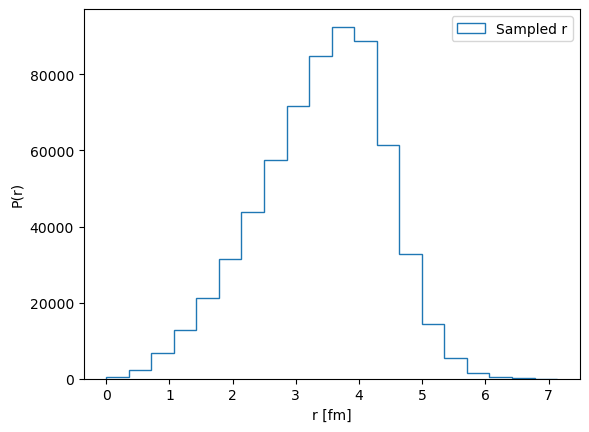

C:\Users\smula\AppData\Local\Temp\ipykernel_18880\4032349443.py:206: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for l in leg.legendHandles:


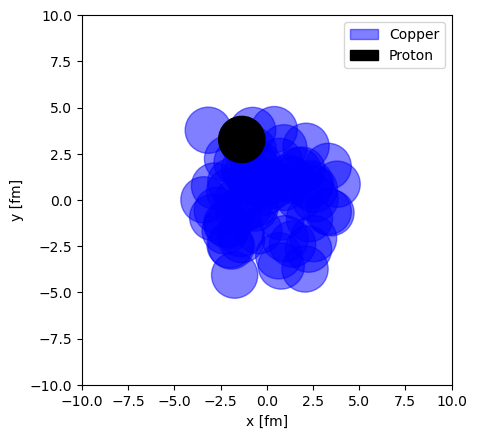

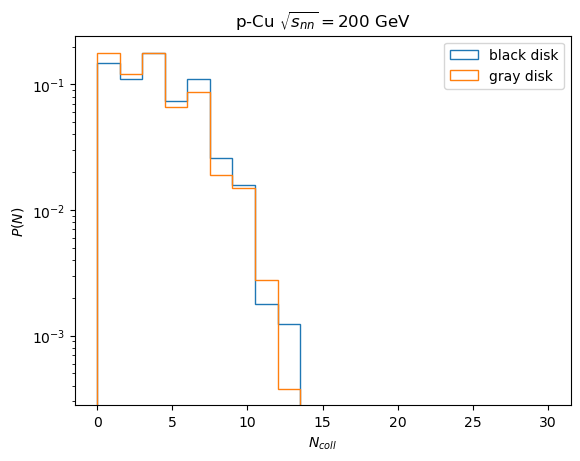

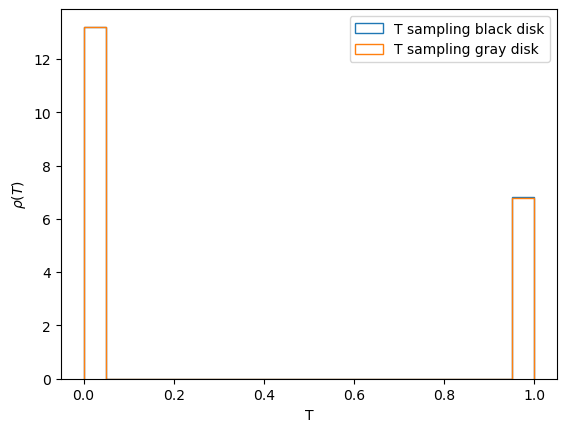

In [13]:
#plotting

#b sampling
plt.hist(b_arr, range=[0,bMax+1], histtype='step', bins=20, density=True, label='sampled b')
plt.xlabel('b [fm]')
plt.ylabel(r'$1/N dN/db$')
plt.legend()
plt.show()

rv = [n.r() for nu in nuclei for n in nu.nucleons]

counts, bins = np.histogram(rv,bins=20,density=True)
dV = [(bins[i+1]**3-bins[i]**3)/bins[len(bins)-1]**3 for i in range(0,len(bins)-1)]
wcounts = [c/dVV for dVV, c in zip(dV,counts)]

# Normalizing such that rho(0) = 1 as per convention.
norm = wcounts[0]
wcounts = [c/norm for c in wcounts]

# Plotting
plt.stairs(wcounts,bins,label="Sampled nucleons per volume element")

# Compare to the density.
def wsFunction(x,A):
    R = 1.12*A**(1/3)-0.86*A**(-1/3)
    a = 0.459
    return 1/(1+np.exp((x-R)/a))

x = np.linspace(0,15, 10000)
plt.plot(x,wsFunction(x,A),label="Woods Saxon density")
plt.ylabel(r"$\rho(r)/\rho_0$")
plt.xlabel("b [fm]")
plt.legend()
plt.show()


plt.hist(rv, range=[0,max(rv)], bins=20, histtype='step', label = 'Sampled r' )
plt.xlabel('r [fm]')
plt.ylabel('P(r)')
plt.legend()
plt.show()

fig3 = plt.figure()
ax3 = fig3.add_subplot(1,1,1)
Au.setup()
xc = [n.bx for n in Au.nucleons]
yc = [n.by for n in Au.nucleons]

# Add a test proton at some impact parameter to see if everything works as it should.
testProton = Nucleon(0,0,0)

# You could play around with different impact parameters. I also like to visualize things.
testProton.shift(impact[0][0],impact[0][1])

gscatter(ax3, xc, yc, color='blue', label='Copper', alpha=0.5)
gscatter(ax3, [testProton.bx], [testProton.by], color='black', label='Proton')
plt.show()


#plotting the probability for ncoll
plt.hist(Ncoll, range = [0,30], bins = 20, density = True, histtype = 'step', label=r"black disk")
plt.hist(Ncoll_g, range = [0,30], bins = 20, density = True, histtype = 'step', label=r"gray disk")
plt.xlabel(r'$N_{coll}$')
plt.ylabel(r'$P(N)$')
plt.yscale('log')
plt.title(r'p-Cu $\sqrt{s_{nn}}=200$ GeV')
plt.legend()
plt.show()


plt.hist(Ts_bDisk_list[0], bins=20, histtype='step', density=True, label='T sampling black disk')
plt.hist(Ts_gDisk_list[0], bins=20, histtype='step', density=True, label='T sampling gray disk')
plt.xlabel('T')
plt.ylabel(r'$\rho(T)$')
plt.legend()
plt.show()

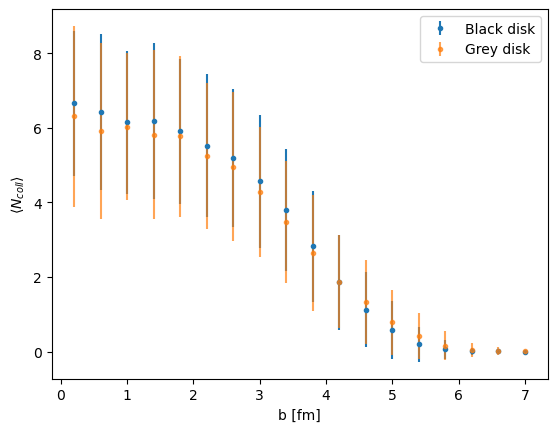

In [14]:
import scipy.stats

def avg_Ncoll(Ncoll_all):
    means_result = scipy.stats.binned_statistic([i[0] for i in impact], [Ncoll_all, [n**2 for n in Ncoll_all]], 
                                                bins=20, range=(0,8), statistic='mean')
    means, means2 = means_result.statistic
    standard_deviations = np.sqrt(means2 - means**2)
    bin_edges = means_result.bin_edges
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    return bin_centers, means, standard_deviations

bin_centers_b, means_b, standard_deviations_b = avg_Ncoll(Ncoll_all)
bin_centers_g, means_g, standard_deviations_g = avg_Ncoll(Ncoll_all_g)
plt.errorbar(x=bin_centers_b, y=means_b, yerr=standard_deviations_b, linestyle='none', marker='.', label='Black disk')
plt.errorbar(x=bin_centers_g, y=means_g, yerr=standard_deviations_g, linestyle='none', marker='.', label='Grey disk', alpha=0.7)
plt.xlabel('b [fm]')
plt.ylabel(r'$\langle N_{coll} \rangle$')
plt.legend()